## Import relavent Libraries

In [1]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import sys
import math

## Visualise given images

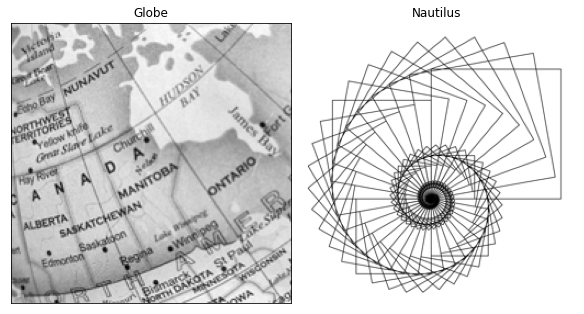

In [2]:
img1 = imageio.imread("Globe.png")
img2 = imageio.imread("Nautilus.png")
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(8,8), constrained_layout=True)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.imshow(img1, 'gray')
ax1.title.set_text('Globe')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.imshow(img2, 'gray')
ax2.title.set_text('Nautilus')
plt.axis('off')
plt.show()

## Space Variant Blurring

For an image, a corresponding $\sigma$-map can be defined as given in the problem statement as $\sigma(m,n) = A e^{-((m-N/2)^2+(n-N/2)^2)/B}$. For the given image of the Globe, $\sigma(0,0) = 2.0$ and $\sigma(N/2,N/2) = 0.01$, we can compute the values of A and B for the $\sigma$- map. For every pixel there is a corresponding sigma value and a an associated Gaussian blur kernel. We apply the kernels across all pixels and subsequently sum the intensities to get the final blurred image.

In [3]:
def AB (img, val_0, val_N2):
    [N,M] = np.shape(img)
    A = val_N2
    B = N**2/(2*np.log(A/val_0))
    return A, B

In [4]:
def sigma_map(A,B,img):
    [N,M] =  np.shape(img)
    s_map = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            s_map[i,j] = A*np.exp((-((i-N/2)**2+(j-N/2)**2)/B))
    return s_map

In [5]:
def Space_Variant_Gaussian_blurring(s_map,img):
    [x,y] =  np.shape(img)
    sigma_max = np.max(s_map)
    kernel_max = math.ceil(6*sigma_max+1)
    if (kernel_max%2==0):
        kernel_max = kernel_max+1
    d_max = kernel_max//2
    blurred_image = np.zeros((x+2*d_max,y+2*d_max))
    padded_image = np.zeros((x+2*d_max,y+2*d_max))
    padded_image[d_max:-d_max,d_max:-d_max] = img
    for i in range (d_max, x+d_max):
        for j in range (d_max, y+d_max):
            ii = i-d_max
            jj = j-d_max
            sigma = s_map[ii,jj]
            # Get kernel size
            kernel_size = math.ceil(6*sigma+1)

            # We ensure that the kernel is odd sized
            if (kernel_size%2)==0 :
                kernel_size = kernel_size + 1
            d = (kernel_size)//2
            intensity = img[ii, jj]
            
            if kernel_size==1:
                blurred_image[i,j]+=img[ii,jj]
                continue
                
            # Get blur kernel
            blur_kernel = np.zeros((kernel_size,kernel_size))
            for m in range(kernel_size):
                for n in range(kernel_size):
                    blur_kernel[m, n] = np.exp((-(m-d)**2-(n-d)**2)/(2*(sigma**2)))
            blur_kernel = blur_kernel/np.sum(blur_kernel)
            
            blurred_image[i-d:i+d+1, j-d:j+d+1] += intensity*blur_kernel
    return blurred_image[d_max:-d_max,d_max:-d_max]

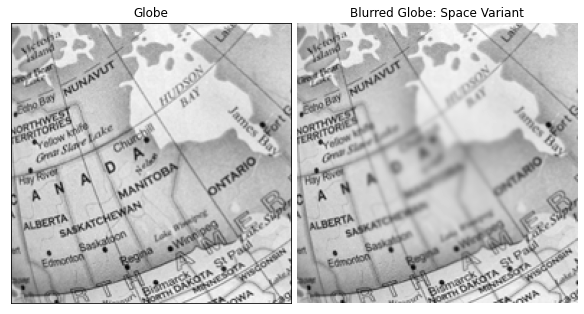

In [6]:
[A,B] = AB(img1,0.01,2)
s_map1 = sigma_map(A,B,img1)
blur_image1 = Space_Variant_Gaussian_blurring(s_map1,img1)
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(8,8), constrained_layout=True)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.imshow(img1, 'gray')
ax1.title.set_text('Globe')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.imshow(blur_image1, 'gray')
ax2.title.set_text('Blurred Globe: Space Variant')
plt.axis('off')
plt.show()

## Space Invariant Blur

We do the same as done in the previous assignment

In [7]:
def Space_Invariant_Gaussian_blurring(sigma,img):
    
    # Get kernel size
    kernel_size = math.ceil(6*sigma+1)
    
    # We ensure that the kernel is odd sized
    if (kernel_size%2)==0 :
        kernel_size = kernel_size + 1
    d = (kernel_size)//2
    
    # If the kernel size is 1, the resultant blurring is none. The original image can be returned
    if kernel_size == 1:
        return img
    
    # Get blur kernel
    blur_kernel = np.zeros((kernel_size,kernel_size))
    for i in range(kernel_size):
        for j in range(kernel_size):
            blur_kernel[i, j] = np.exp((-(i-d)**2-(j-d)**2)/(2*(sigma**2)))
    blur_kernel = blur_kernel/np.sum(blur_kernel)
    
    # Perform blurring
    # Get image shape
    [x,y] = np.shape(img)
    
    # Create blur image
    blurred_image = np.zeros((x,y))
    for i in range(x):
        for j in range(y):
            
            # We ensure that the blur kernel is accordingly sized for pixels along the borders as well
            if i<d:
                i_start = 1
                i_end = i+d
                kernel_i_start = d-i+2
                kernel_i_end = 2*d+1
            elif i>x-d :
                i_start = i-d
                i_end = x
                kernel_i_start = 1
                kernel_i_end = x-i+d+1
            else :
                i_start = i-d
                i_end = i+d
                kernel_i_start = 1
                kernel_i_end = 2*d+1
            if j<d:
                j_start = 1
                j_end = j+d
                kernel_j_start = d-j+2
                kernel_j_end = 2*d+1
            elif j>y-d :
                j_start = j-d
                j_end = y
                kernel_j_start = 1
                kernel_j_end = y-j+d+1
            else :
                j_start = j-d
                j_end = j+d
                kernel_j_start = 1
                kernel_j_end = 2*d+1
            
            # Get the patch of image on which blurring is done
            patch = img[i_start:i_end, j_start:j_end]
            
            # Get the resized, normalised kernel for the patch
            kernel = blur_kernel[kernel_i_start:kernel_i_end,kernel_j_start:kernel_j_end]/np.sum(blur_kernel[kernel_i_start:kernel_i_end,kernel_j_start:kernel_j_end])
            
            # Blurred pixed value
            blurred_image[i, j] = np.sum(kernel*patch)
    
    # Return blurred image
    return blurred_image

## Space Invariant Blur: A case of Space Variant Blur

For the Nautilus image given we apply space invariant blur as done in the previous assignment. We compare it with a special case of sigma-map where $\sigma = 1$ throughout

In [8]:
SI_blur_image = Space_Invariant_Gaussian_blurring(1,img2)
[N,M] = np.shape(img2)
SV_blur_image = Space_Variant_Gaussian_blurring(np.ones((N,N)),img2)

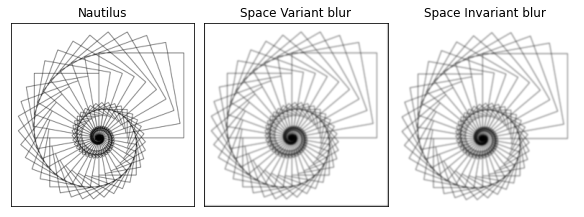

In [9]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(8,8), constrained_layout=True)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.imshow(img2, 'gray')
ax1.title.set_text('Nautilus')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.imshow(SV_blur_image, 'gray')
ax2.title.set_text('Space Variant blur')
ax3.set_xticks([])
ax3.set_yticks([])
ax3.imshow(SI_blur_image, 'gray')
ax3.title.set_text('Space Invariant blur')
plt.axis('off')
plt.show()

## Observations

1. Higher the sigma value, greater the blur radius. The $\sigma$-map in the space variant blurring of the globe has higher sigma values at the centre and lower as you move away from the centre. The corresponding blur also decreases as we move away from the centre.
2. When the values of $\sigma$s in the $\sigma$-map is the same throughout, then the space variant blur given rise to space invariant blur.